# IVOL Puzzle - Idiosyncratic Volatility

## Setup

In [ ]:
import torch
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from datetime import datetime
import numpy as np
import seaborn as sns
from scipy.stats import percentileofscore

import wrds
import statsmodels.api as sm

plt.style.use('seaborn-v0_8-notebook')
eps = 1e-8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.figsize'] = [10, 6]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.autolayout'] = True

conn = wrds.Connection(wrds_username = 'xianlifu')
conn.create_pgpass_file()

Loading library list...
Done


## Data Access - Stocks universe

In line with Stambaugh's methodology, we use all NYSE/AMex/NASDAQ stocks with share prices greater than five dollars.

Stambaugh's research covered data from 1965 to 2011. We retrieve data from 1965 to 2024.

Our stock universe is the series of tickers for each month where the stock price is above five dollars.

In [253]:
start = '1965-01-01'
end = '2025-01-01'

In [256]:
# we begin by extracting all permnos in our universe
permnos = conn.raw_sql(
    f"""
    SELECT DISTINCT permno
    FROM crsp.msenames
    WHERE namedt BETWEEN '{start}' AND '{end}'
    AND exchcd in (1, 2, 3)
    """
)
permnos

,permno
0,83264
1,63618
2,10896
3,69906
4,79030
...,...
33695,81454
33696,79163
33697,86036
33698,92970


We generate a list of month-end dates between the start and end of our dataset.

In [257]:
dates = pd.date_range(
    start=start,
    end=end,
    freq='ME'
)
dates

DatetimeIndex(['1965-01-31', '1965-02-28', '1965-03-31', '1965-04-30',
               '1965-05-31', '1965-06-30', '1965-07-31', '1965-08-31',
               '1965-09-30', '1965-10-31',
               ...
               '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30',
               '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31',
               '2024-11-30', '2024-12-31'],
              dtype='datetime64[ns]', length=720, freq='ME')

In [ ]:
apple_series = conn.raw_sql(
    f"""
    SELECT eom, niq_at
    FROM contrib_global_factor.global_factor
    WHERE permno = 10107
    AND eom BETWEEN '{start}' AND '{end}'
    ORDER BY eom
    """
)

In [ ]:
# Split 'permnos' DataFrame into 4 chunks and write each to a CSV file
# This is done to avoid memory issues when processing large DataFrames.
# Each chunk will be processed separately in separate notebooks, and written into four separate CSV files.
# This is a workaround to avoid memory issues when processing large DataFrames.

# chunks = np.array_split(permnos, 4)
# for i, chunk in enumerate(chunks, start=1):
#     chunk.to_csv(f'permnos_{i}.csv', index=False)

permnos_chunk = pd.read_csv('permnos_1.csv')

# Create a DataFrame with the dates series as the first column (dates is defined in a previous cell)
result_df_1 = pd.DataFrame({'date': dates})

total_permnos = len(permnos_chunk)
for i, permno in enumerate(permnos_chunk['permno']):
    print(f"Processing permno {permno} ({i+1}/{total_permnos})", end='\r')
    query = f"""
    SELECT eom AS date, o_score
    FROM contrib_global_factor.global_factor
    WHERE permno = {permno}
    AND date BETWEEN '{start}' AND '{end}'
    ORDER BY date
    """
    df_permno = conn.raw_sql(query, date_cols=['date'])
    df_permno = df_permno.rename(columns={'o_score': str(permno)})
    result_df_1 = result_df_1.merge(df_permno, on='date', how='left')

result_df_1.to_csv('result_df_1.csv', index=False)

In [159]:
oscore_1 = pd.read_csv('result_df_1.csv', parse_dates=['date']).set_index('date')
oscore_2 = pd.read_csv('result_df_2.csv', parse_dates=['date']).set_index('date')
oscore_3 = pd.read_csv('result_df_3.csv', parse_dates=['date']).set_index('date')
oscore_4 = pd.read_csv('result_df_4.csv', parse_dates=['date']).set_index('date')

oscore_raw = pd.concat([oscore_1, oscore_2, oscore_3, oscore_4], axis=1)
oscore_raw = oscore_raw.reset_index()

print(oscore_raw.shape)
print(oscore_raw.head())

(720, 33701)
        date  83264  63618  10896  69906  79030  11233  44127  86580  91786  \
0 1965-01-31    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1 1965-02-28    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2 1965-03-31    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3 1965-04-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4 1965-05-31    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   ...  56120  31713  85792  83586  89403  81454  79163  86036  92970  19812  
0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
1  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
3  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
4  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[5 rows x 33701 columns]


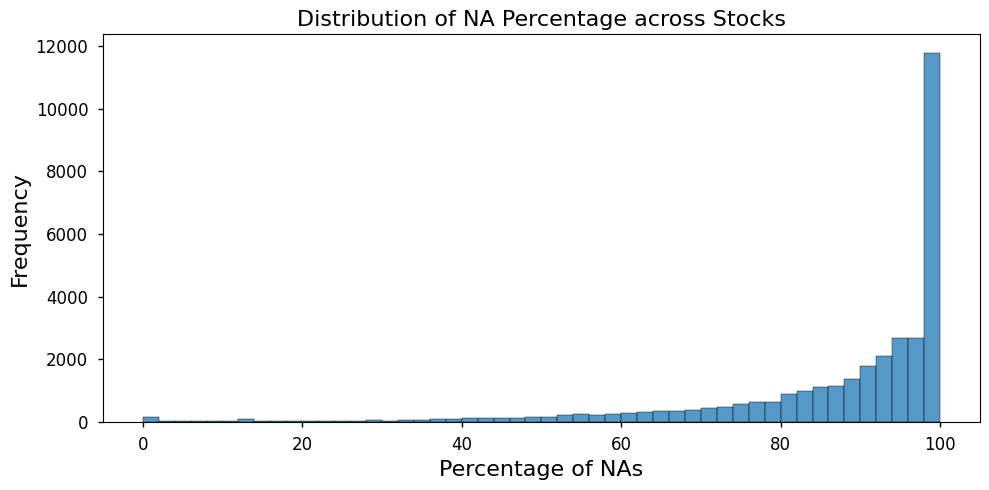

In [160]:
# Exclude the 'date' column and compute the percentage of NAs for each stock column
na_pct = oscore_raw.drop('date', axis=1).isna().mean() * 100

# Plot the distribution of NA percentages
plt.figure(figsize=(10, 5))
sns.histplot(na_pct, bins=50)
plt.xlabel("Percentage of NAs")
plt.ylabel("Frequency")
plt.title("Distribution of NA Percentage across Stocks")
plt.show()

In [161]:
# Assume oscore_raw is your existing DataFrame with shape (720 x 33701)
# - The first column is 'date'
# - The remaining ~33700 columns are stocks

# 1) Make a copy so we don’t overwrite the original data
oscore_pct = oscore_raw.copy()

# 2) Extract the 'date' column so we can temporarily remove it from the DataFrame
date_col = oscore_pct['date']

# 3) Drop the 'date' column before ranking
oscore_pct.drop(columns=['date'], inplace=True)

# 4) Compute row-wise percentile ranks (ignore NaNs by default).
#    - axis=1 → operate across columns for each row
#    - pct=True → output in [0, 1] range
#    - Ties are averaged by default. NA remains NA.
oscore_pct = oscore_pct.rank(pct=True, axis=1)

# 5) Re-insert the date column as the first column
oscore_pct.insert(0, 'date', date_col)
oscore_pct = oscore_pct.set_index('date')

# The shape remains (720 x 33701).
# Each non-NA cell is now the percentile of o_score among all columns for that row.
oscore_pct.head  # Should be (720, 33701)

# Optional: Save to CSV
# oscore_pct.to_csv('oscore_pct.csv', index=False)

<bound method NDFrame.head of                83264  63618  10896  69906  79030  11233  44127     86580  \
date                                                                       
1965-01-31       NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
1965-02-28       NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
1965-03-31       NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
1965-04-30       NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
1965-05-31       NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN   
...              ...    ...    ...    ...    ...    ...    ...       ...   
2024-08-31  0.497082    NaN    NaN    NaN    NaN    NaN    NaN  0.006269   
2024-09-30  0.498917    NaN    NaN    NaN    NaN    NaN    NaN  0.006281   
2024-10-31  0.505296    NaN    NaN    NaN    NaN    NaN    NaN  0.006269   
2024-11-30  0.489161    NaN    NaN    NaN    NaN    NaN    NaN  0.004986   
2024-12-31  0.490309    NaN    NaN    NaN    NaN    NaN   

In [181]:
# oscore_pct.to_csv('oscore_pct.csv', index=False)
oscore_pct.shape

(720, 33700)

<Axes: title={'center': 'Apple O-Score Percentile'}>

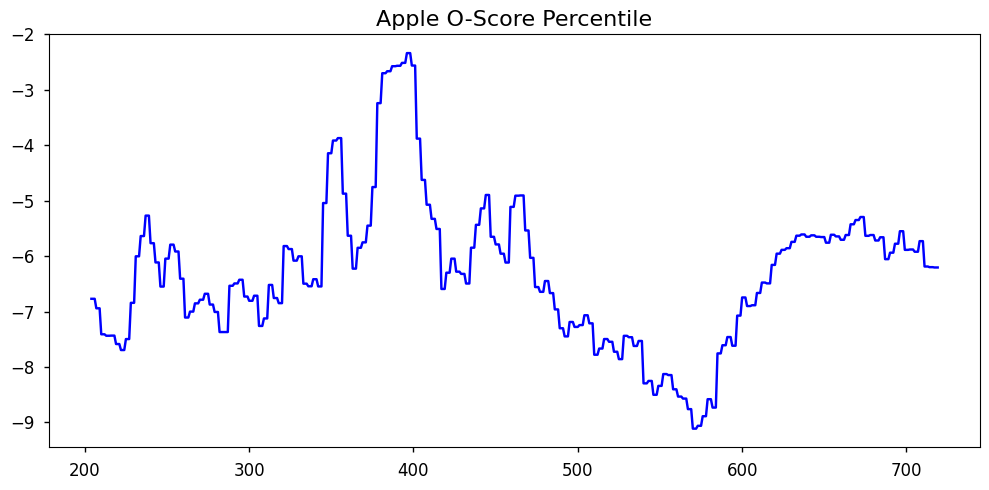

In [195]:
oscore_raw['14593'].plot(title='Apple O-Score Percentile', figsize=(10, 5), color='blue')

In [258]:
# ------------------------------------------------------------------
# 1) Split permnos into chunks (for memory reasons)
# ------------------------------------------------------------------
# chunks = np.array_split(permnos, 4)  # or however many chunks you want

# Example: We'll process just the first chunk here
permnos_chunk = pd.read_csv('permnos_1.csv')

# Suppose we have these variables to pull

all_anomalies = ['prc', 'me', 'ret', 'o_score', 'chcsho_12m', 'oaccruals_at', 'noa_at', 'ret_12_1', 'gp_at', 'at_gr1', 'niq_at', 'capx_at']
# Using capex-to-assets as ratio for investment-to-assets

# Create a comma-separated string out of the list
anomalies_str = ", ".join(all_anomalies)

# Create an empty list to store per-permno long DataFrames.
df_list = []

# --------------
# Loop over each permno in the chunk
# --------------
for i, permno in enumerate(permnos_chunk['permno']):
    print(f"Processing permno {permno} ({i+1}/{len(permnos_chunk)})", end='\r')
    
    query = f"""
        SELECT eom, {anomalies_str}
        FROM contrib_global_factor.global_factor
        WHERE permno = {permno}
          AND eom BETWEEN '{start}' AND '{end}'
          AND prc >= 5
        ORDER BY eom
    """
    # Open a connection (or reuse an existing one)
    # Here we assume a connection "conn" is already open.
    df_tmp = conn.raw_sql(query, date_cols=['eom'])
    
    # If no data is returned for this permno, skip it
    if df_tmp.empty:
        continue
    
    # Melt df_tmp to long format so each row corresponds to (eom, variable, value)
    df_long = df_tmp.melt(
        id_vars=['eom'], 
        value_vars=all_anomalies,
        var_name='variable',   # e.g., 'o_score', 'price', or 'accruals'
        value_name='value'
    )
    
    # Add a column for this permno
    df_long['permno'] = permno
    df_list.append(df_long)

# --------------
# Concatenate all long DataFrames (vertical concatenation)
# --------------
df_all = pd.concat(df_list, axis=0)
# Columns in df_all: ['eom', 'variable', 'value', 'permno']

# --------------
# Pivot to get a wide DataFrame:
#   - The index will be the combination of variable and eom.
#   - Columns will be the unique permnos.
#   - Values are taken from 'value'.
# --------------
df_wide = df_all.pivot(index=['variable', 'eom'], columns='permno', values='value')

# --------------
# Reset index so that 'variable' and the date appear as ordinary columns.
# Rename 'eom' to 'date' to match your terminology.
# --------------
df_wide = df_wide.reset_index()
df_wide.rename(columns={'eom': 'date'}, inplace=True)

# --------------
# Optional: If you require exactly one date column and want to drop the variable column
# from the data (and you know that the rows are ordered in blocks of 720 for each variable)
# you can later split df_wide into three separate DataFrames.
# Otherwise, df_wide now has three columns for each variable:
#   * The first two columns are 'variable' and 'date'
#   * The remaining 33700 columns correspond to permnos.
# --------------
print(df_wide.shape)
# Expected shape: (2160, 33702) meaning 2160 rows (3 variables * 720 dates)
#             and 1 ('variable') + 1 ('date') + 33700 (permnos) columns.

# Optional: Save to CSV
df_wide.to_csv('df_wide_1.csv', index=False)

(8640, 7677)ermno 83557 (8425/8425)


In [259]:
anomalies_1 = pd.read_csv('df_wide_1.csv', parse_dates=['date']).set_index('date')
anomalies_2 = pd.read_csv('df_wide_2.csv', parse_dates=['date']).set_index('date')
anomalies_3 = pd.read_csv('df_wide_3.csv', parse_dates=['date']).set_index('date')
anomalies_4 = pd.read_csv('df_wide_4.csv', parse_dates=['date']).set_index('date')

anomalies_raw = pd.concat([anomalies_1, anomalies_2, anomalies_3, anomalies_4], axis=1)
anomalies_raw = anomalies_raw.reset_index()

print(anomalies_raw.shape)
print(anomalies_raw.head())

(8640, 30659)
        date variable  10003  10007  10010  10016  10017  10021  10027  10031  \
0 1965-01-31   at_gr1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1 1965-02-28   at_gr1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2 1965-03-31   at_gr1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3 1965-04-30   at_gr1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4 1965-05-31   at_gr1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   ...  93371  93374  93384  93390  93392  93395  93397  93427  93428  93435  
0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
1  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
3  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
4  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[5 rows x 30659 columns]

In [262]:
anomalies_raw = anomalies_raw.loc[:, ~anomalies_raw.columns.duplicated()]
print("Shape after dropping duplicate columns:", anomalies_raw.shape)

Shape after dropping duplicate columns: (8640, 30656)


In [264]:
anomalies_raw.to_csv("anomalies_raw_new.csv", index = False)

<Axes: title={'center': 'Apple O-Score Percentile'}>

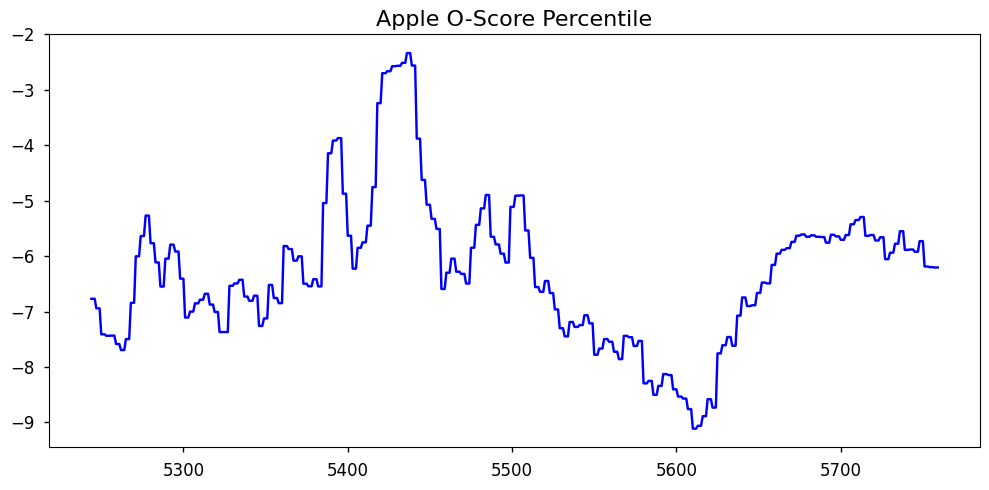

In [ ]:
anomalies_raw.loc[anomalies_raw['variable'] == 'o_score', '14593'].plot(title='Apple O-Score Absolute', figsize=(10, 5), color='blue')

In [252]:
# ----------------------------
# Assumptions:
# - anomalies_raw is your 6480 x 33701 DataFrame
#     * Column 0: 'date'
#     * Column 1: 'variable'  (one of 9)
#     * The remaining ~33700 columns represent stocks;
#       their column names are the permnos stored as integers.
# - conn is your live WRDS connection.
# ----------------------------

# Make a copy so we don’t modify the original
anomalies_pct = anomalies_raw.copy()

new_cols = {}
for col in anomalies_pct.columns:
    if col in ['date', 'variable']:
        continue
    try:
        new_cols[col] = int(col)
    except ValueError:
        pass

anomalies_pct.rename(columns=new_cols, inplace=True)


# Get the unique dates (720 unique end‑of‑month dates)
unique_dates = anomalies_pct['date'].unique()
total_dates = len(unique_dates)

for i, date in enumerate(unique_dates):
    if i > 2:
        break
    print(f"Processing {date}")
    permnos = conn.raw_sql(
        f"""
            SELECT permno
            FROM crsp.msf
            WHERE date = '{date.strftime("%Y-%m-%d")}'
            AND prc >= 5
        """
    ).set_index('permno')
    if permnos.shape[0] == 0:
        permnos = conn.raw_sql(
            f"""SELECT DISTINCT ON (permno) permno, prc, date
            FROM crsp.msf
            WHERE date <= '{date.strftime("%Y-%m-%d")}'
            ORDER BY permno, date DESC"""
        )
        permnos = permnos[permnos['prc'] >= 5].set_index('permno')

    
    valid_permnos = anomalies_pct.columns[
        anomalies_pct.columns.isin(permnos.index)
    ]

    print(f"{valid_permnos}")

    for var in anomalies_raw['variable'].unique():
        X = anomalies_pct[
            (anomalies_pct['date'] == date)*(anomalies_pct['variable']==var)
        ][valid_permnos].dropna()
        print(f"first debug X: {X}")


        for permno in valid_permnos:
            x = anomalies_pct[
                (anomalies_pct['date'] == date)*(anomalies_pct['variable']==var)
            ][permno].iloc[0]
            if x is not None:
                print(f"x: {x}")
                print(f"X: {X}")
                
                score = percentileofscore(X, x)
                print(f"Score: {score}")

                anomalies_pct[
                    (anomalies_pct['date'] == date)*(anomalies_pct['variable']==var)
                ][permno] = score
                print(f"{date}, {var}, {permno}, {score}")
            else:
                anomalies_pct[
                    (anomalies_pct['date'] == date)*(anomalies_pct['variable']==var)
                ][permno] = np.nan
    

# for idx_date, date_val in enumerate(unique_dates, start=1):
#     # Format the current date for SQL (YYYY-MM-DD)
#     date_str = pd.to_datetime(date_val).strftime('%Y-%m-%d')
#     print(f"Processing date {date_str} ({idx_date}/{total_dates})", end='\r')
    
#     # --------------------------------------------------------------------------
#     # 1. Run a SQL query to pull the allowed permnos (stocks with prc >= 5)
#     #    We pull from crsp.msf (which should be faster) and let the SQL do the filtering.
#     # --------------------------------------------------------------------------
#     query = f"""
#         SELECT permno
#         FROM crsp.msf
#         WHERE date = '{date_str}'
#         AND prc >= 5
#     """
#     prices = conn.raw_sql(query).set_index('permno')
    
#     # If no rows are returned, fall back: get the most recent row on or before date_str
#     if prices.empty:
#         query = f"""
#             SELECT DISTINCT ON (permno) permno, prc, date
#             FROM crsp.msf
#             WHERE date <= '{date_str}'
#             ORDER BY permno, date DESC
#         """
#         prices = conn.raw_sql(query)
#         prices = prices[prices['prc'] >= 5].set_index('permno')
    
#     # Extract allowed permnos as a list of integers (the column names in anomalies_pct)
#     allowed_permnos = prices['permno'].tolist()
    
#     # --------------------------------------------------------------------------
#     # 2. Find the rows in anomalies_pct corresponding to this date.
#     #    (For each of the 9 variables that share that date.)
#     # --------------------------------------------------------------------------
#     date_mask = anomalies_pct['date'] == date_val
#     sub_indices = anomalies_pct.index[date_mask]
    
#     # --------------------------------------------------------------------------
#     # 3. For each such row:
#     #    a. Use boolean filtering on the stock columns (all except 'date' and 'variable')
#     #       to identify those columns whose name is in allowed_permnos.
#     #    b. For the columns that are NOT allowed, set their value to NaN.
#     #    c. Compute the row-wise percentile rank on the allowed (remaining) values.
#     # --------------------------------------------------------------------------
#     for i in sub_indices:
#         # Get the row (make a copy to avoid chained assignment issues)
#         row = anomalies_pct.loc[i]
#         # Identify the stock columns
#         stock_cols = row.index.difference(['date', 'variable'])
        
#         # Create a boolean mask indicating for each stock column whether it is allowed.
#         allowed_mask = stock_cols.isin(allowed_permnos)
        
#         # Identify columns to set to NaN (i.e. not allowed)
#         cols_to_na = stock_cols[~allowed_mask]
#         # Set non-allowed columns in this row to NaN
#         anomalies_pct.loc[i, cols_to_na] = np.nan
        
#         # Compute the percentile ranks across the stock columns (ignoring NaNs)
#         # This produces a series with the same index as stock_cols.
#         ranked = anomalies_pct.loc[i, stock_cols].rank(pct=True)
#         # Update only the stock columns with the percentile values
#         anomalies_pct.loc[i, stock_cols] = ranked

# print("\nDone processing all unique dates.")

# # Optionally set 'date' as the index
# anomalies_pct = anomalies_pct.set_index('date')

# # Check the output
# print(anomalies_pct.head())
# print(anomalies_pct.shape)


Processing 1965-01-31 00:00:00
Index([10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823,
       ...
       41072, 41152, 41187, 41347, 41419, 41486, 41494, 53023, 68523, 86239],
      dtype='object', length=1486)
first debug X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 12466, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 12650, nan
x: -0.0100599550337247
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 1087

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 15544, nan
x: 0.1582895723930982
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 15579, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 17902, nan
x: 0.0442622950819671
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 18032, nan
x: 0.1164288798687279
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 1082

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 21151, nan
x: 0.0274614984301995
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 21207, nan
x: 0.3623395149786022
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 1082

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: 0.0489864028253472
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 23085, nan
x: 0.0412887924645257
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 24491, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 24512, nan
x: -0.0111490031479538
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 1087

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 26016, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 1198

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 27094, nan
x: -0.0067264573991032
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 27238, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 1087

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: 0.046
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 28097, nan
x: 0.0310344827586206
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 1

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 29719, nan
x: 0.091286537526904
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 29890, nan
x: 0.0276422764227641
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 31587, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 31616, nan
x: -0.0079365079365079
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 1087

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: 0.08
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 34331, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 119

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 36783, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 1198

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: 0.0855057351407715
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 39300, nan
x: 0.1038717735220649
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 40651, nan
x: 0.2777777777777777
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 40694, nan
x: 0.8199999999999998
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 1082

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: -0.0150375939849624
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 10620, nan
x: 0.0140186915887849
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 1

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 12546, nan
x: 0.3007920792079208
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 12626, nan
x: 0.0289293555469456
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 1082

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 14605, nan
x: 0.3227401129943503
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 14760, nan
x: 0.1238095238095238
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 1082

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: 0.1097638800255265
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 17953, nan
x: 0.0885647328600138
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: 0.0643939393939394
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 20175, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 116

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: -0.0135557872784151
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 21864, nan
x: -0.0120538243626062
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 23464, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 23480, nan
x: 0.1215277777777777
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 24643, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 24862, nan
x: 0.3102766798418972
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: 0.0777327120973419
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 26470, nan
x: 0.0
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 116

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 27115, nan
x: 0.0783582089552237
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 27131, nan
x: 0.0496575342465752
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 1082

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 29073, nan
x: 0.5454545454545452
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 29145, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 31376, nan
x: 0.078125
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754,

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 33291, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 33371, nan
x: 0.4833333333333334
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 34868, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 34876, nan
x: 0.0208333333333334
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 35772, nan
x: -0.0471698113207547
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 38180, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 38340, nan
x: 0.3173076923076923
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 39765, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 39829, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938,

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 41507, nan
x: -0.0454545454545454
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 58149, nan
x: 0.0876494023904381
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 108

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 12888, nan
x: 0.0436162964981603
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 12976, nan
x: 0.1299638989169676
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 1082

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: -0.1027227722772277
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 15034, nan
x: -0.0167464114832535
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 18059, nan
x: -0.0328891656288915
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 18067, nan
x: -0.0198847483672686
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 19676, nan
x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 19684, nan
x: 0.1045982532751091
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: 0.0720855274227201
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 21768, nan
x: 0.1761904761904762
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 22971, nan
x: -0.0276243093922652
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 24379, nan
x: 0.0805860805860805
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 24459, nan
x: 0.0092851093196146
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 1082

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

x: nan
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 26139, nan
x: -0.0258904109589041
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

1965-01-31 00:00:00, at_gr1, 27465, nan
x: 0.043956043956044
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823, 10866, 10874, 10890, 10938, 11148, 11260, 11295, 11674, 11754, 11981, 12036, 12060, 12167, 12183, 12431, 12458, 12466, 12650, 12837, 13100, 13119, 13135, 13143, 13311, 13354, 13370, 13565, 13661, 13792, 13901, 13928, 14218, 14250, 14277, 14322, 14429, 14752, 14824, 14859, 14867, 14883, 14891, 15050, 15317, 15341, 15368, 15528, 15544, 15579, 15624, 15659, 15763, 15915, 16109, 16336, 16424, 16432, 16600, 17005, 17128, 17291, 17515, 17566, 17670, 17734, 17742, 17822, 17902, 18032, 18163, 18198, 18251, 18278, 18358, 18550, 18622, 18796, 18956, 19107, 19131, 19254, 19289, 19377, 19561, 20079, 20124, 20132, 20204, 20474, 20482, ...]
Index: []

[0 rows x 1486 columns]
Score: nan
1965-01-31 00:00:00, at_gr1, 27502, nan
x: -0.055350553505535
X: Empty DataFrame
Columns: [10102, 10161, 10233, 10313, 10372, 10436, 10487, 10495, 10786, 10823

C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pct[
C:\Users\xianl\AppData\Local\Temp\ipykernel_18972\2595982804.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

KeyboardInterrupt: 

In [ ]:
# - The first column is 'date'
# - The remaining ~33700 columns are stocks

# 1) Make a copy so we don’t overwrite the original data
anom_pct = anomalies_raw.copy()

# 2) Extract the 'date' and 'variable' columns so we can temporarily remove them from the DataFrame
date_col = anom_pct.pop('date')
variable_col = anom_pct.pop('variable')

# 3) Compute row-wise percentile ranks on the remaining numerical columns
#    - axis=1 → operate across columns for each row
#    - pct=True → output in [0, 1] range
#    - Ties are averaged by default. NA remains NA.
anom_pct = anom_pct.rank(pct=True, axis=1)

# 4) Re-insert the 'variable' and 'date' columns as the first columns
anom_pct.insert(0, 'variable', variable_col)
anom_pct.insert(0, 'date', date_col)

# 5) Optionally set 'date' as the index (if required)
anom_pct = anom_pct.set_index('date')

# Check the output
print(anom_pct.head())
print(anom_pct.shape)  # Should be (720, 33701)

           variable  10000  10003  10007  10010  10016  10017  10021  10027  \
date                                                                          
1965-01-31   at_gr1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1965-02-28   at_gr1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1965-03-31   at_gr1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1965-04-30   at_gr1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1965-05-31   at_gr1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

            10031  ...  93371  93374  93384  93390  93392  93395  93397  \
date               ...                                                    
1965-01-31    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1965-02-28    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1965-03-31    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1965-04-30    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN

<Axes: title={'center': 'Apple O-Score Percentile'}, xlabel='date'>

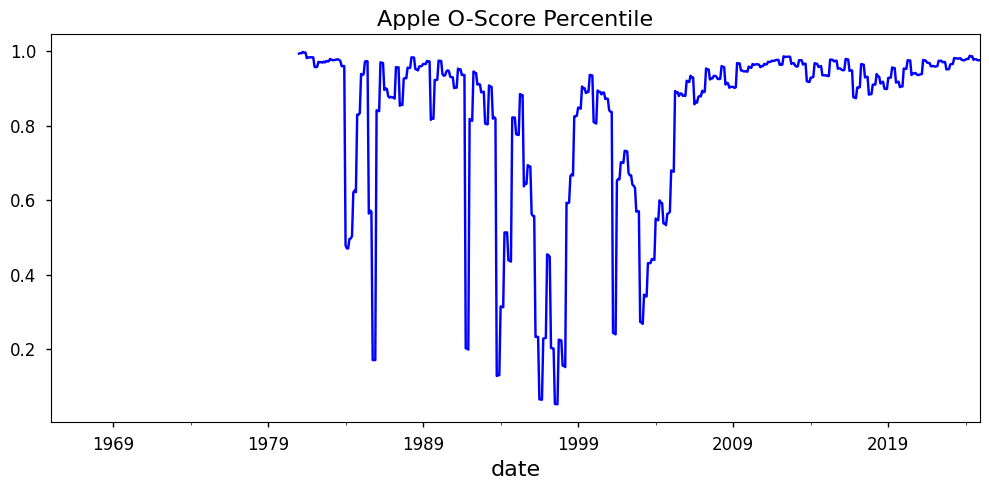

In [202]:
anom_pct[anom_pct['variable'] == 'niq_at']['14593'].plot(title='Apple O-Score Percentile', figsize=(10, 5), color='blue')

In [ ]:
# Optional: Save to CSV
# anom_pct.to_csv('anom_pct.csv', index=False)

## Data Access - IVOL calculation

In [ ]:
month_end_dates = pd.date_range(
    start=start,
    end=end,
    freq='M'
)

factors = conn.raw_sql(
    f"""
    SELECT date, mktrf, smb, hml, rf
    FROM ff.factors_daily
    WHERE date BETWEEN '{start}' AND '{end}'
    """,
    date_cols = ['date']
).set_index('date')

factors = (
    factors.replace([np.inf, -np.inf], np.nan)
    .fillna(0)
    .astype(float)
)

factors

<ipython-input-11-484ff31eadf2>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_end_dates = pd.date_range(


,mktrf,smb,hml,rf
date,,,,
1965-01-04,-0.0045,0.0070,-0.0008,0.00014
1965-01-05,0.0049,0.0038,-0.0009,0.00014
1965-01-06,0.0034,0.0018,0.0042,0.00014
1965-01-07,0.0040,0.0008,0.0019,0.00014
1965-01-08,0.0017,0.0017,-0.0020,0.00014
...,...,...,...,...
2024-12-24,0.0111,-0.0009,-0.0005,0.00017
2024-12-26,0.0002,0.0104,-0.0019,0.00017
2024-12-27,-0.0117,-0.0066,0.0056,0.00017


In [ ]:
permno = tickers['permno'][5]
rets = conn.raw_sql(
    f"""
    SELECT permno, date, ret
    FROM crsp.dsf
    WHERE date BETWEEN '{start}' AND '{end}'
    AND permno = {permno}
    """
)

rets

,permno,date,ret
0,36003,1965-01-04,-0.029508
1,36003,1965-01-05,0.0
2,36003,1965-01-06,0.0
3,36003,1965-01-07,0.016892
4,36003,1965-01-08,0.003322
...,...,...,...
15097,36003,2024-12-24,0.001289
15098,36003,2024-12-26,0.005365
15099,36003,2024-12-27,-0.003629
15100,36003,2024-12-30,-0.005784


In [ ]:
ivol_df = pd.DataFrame(
    index = month_end_dates,
    columns = tickers['permno_ticker'].unique()
)
ivol_df

,"11287,CDL","22461,MCL","22824,SRU","27078,KEL","34358,MOV","36003,ROL","41136,KZ","41427,WPM","41435,PKO","39212,MCB",...,"26023,TAVI","26034,YAAS","25971,TPZ","26003,HIT","25978,NEUP","26012,NTWO","26017,PHH","25995,EGGQ","26031,WLAC","26015,ONEG"
1965-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
tickers['ticker'].nunique()

32087

In [ ]:
for i, col in enumerate(ivol_df.columns[:5]):
    print(f"Processing column {i} out of {len(ivol_df.columns)}", end = '\r')
    t = col.split(',')[1]
    permno = int(col.split(',')[0])

    ret_df = (
        conn.raw_sql(
        f"""
        SELECT date, ret
        FROM crsp.dsf
        WHERE date BETWEEN '{start}' AND '{end}'
        AND permno = {permno}
        """,
        date_cols = ['date'])
        .set_index('date')
        .merge(
            factors['rf'],
            left_index=True,
            right_index=True,
            how='left'
        )
    )

    ret_df['ex_ret'] = ret_df['ret'] - ret_df['rf']


    for idx in ivol_df.index:
        X = np.asarray(
            factors.loc[
                idx - pd.DateOffset(months = 1):idx,
                ['mktrf', 'smb', 'hml']
            ]
        )
        y = np.asarray(
            ret_df.loc[
                idx - pd.DateOffset(months = 1):idx,
                ['ex_ret']
            ]
        )
        X = sm.add_constant(X)
        if X.shape[0] == y.shape[0]:
          model = sm.OLS(y, X).fit()
          ivol = np.std(
              model.resid
          )
          ivol_df.loc[idx, col] = ivol
        else:
          continue

    ivol_df.to_csv('ivol_df.csv')

## Data Access - Return anomalies